In [4]:
%matplotlib inline
from __future__ import division, print_function
import sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib.ticker import NullFormatter
from astropy import units as u
import fitsio
import pandas as pd
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import sys, os, time, argparse, glob
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')

from desitarget.targetmask import desi_mask
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
#from pyvenn import venn
from matplotlib_chord_diagram import matplotlib_chord

In [5]:
def chord(matrix, nodes):
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes([0,0,1,1])

#nodePos = chordDiagram(flux, ax, colors=[hex2rgb(x) for x in ['#666666', '#66ff66', '#ff6666', '#6666ff']])
    nodePos = matplotlib_chord.chordDiagram(matrix, ax)
    ax.axis('off')
    prop = dict(fontsize=16*0.8, ha='center', va='center')
    nodes = nodes#['non-crystal', 'FCC', 'HCP', 'BCC', 'other']
    for i in range(len(matrix)):
        ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][2], **prop)

In [6]:
def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [7]:
class Point:

    def __init__(self, xcoord=0, ycoord=0):
        self.x = xcoord
        self.y = ycoord

class Rectangle:
    def __init__(self, bottom_left, top_right, colour):
        self.bottom_left = bottom_left
        self.top_right = top_right
        self.colour = colour

    def intersects(self, other):
        return not (self.top_right.x <= other.bottom_left.x or self.bottom_left.x >= other.top_right.x or self.top_right.y <= other.bottom_left.y or self.bottom_left.y >= other.top_right.y)
    
    def plot(self, other):
        fig, ax = plt.subplots(figsize=(15,8))
        rect = patches.Rectangle((self.bottom_left.x,self.bottom_left.y), abs(self.top_right.x - self.bottom_left.x), abs(self.top_right.y - self.bottom_left.y),linewidth=1.5, alpha=0.5, color='r')
        rect2 = patches.Rectangle((other.bottom_left.x,other.bottom_left.y), abs(other.top_right.x - other.bottom_left.x), abs(other.top_right.y - other.bottom_left.y),linewidth=1.5, alpha=0.5, color='blue')
        ax.add_patch(rect)
        ax.add_patch(rect2)
        xlims = np.array([self.bottom_left.x, self.top_right.x, other.bottom_left.x, other.top_right.x])
        ylims = np.array([self.bottom_left.y, self.top_right.y, other.bottom_left.y, other.top_right.y])
        ax.set_xlim(xlims.min()-1, xlims.max()+1)
        ax.set_ylim(ylims.min()-1, ylims.max()+1)
        #plt.show()

In [8]:
def cut(ramin, ramax, decmin, decmax, catalog):
    
    mask = np.logical_and(catalog['RA'] >= ramin, catalog['RA'] <= ramax)
    mask &= np.logical_and(catalog['DEC'] >= decmin, catalog['DEC'] <= decmax)
    cat = catalog[mask]
    #print('CUT #:',len(cat))
    
    return cat

In [9]:
def cut_sweeps(ramin, ramax, decmin, decmax, sweep_dir):
    
    cat1_paths = sorted(glob.glob(os.path.join(sweep_dir, '*.fits')))
    #cat = np.empty()
    j = 0
    
    for fileindex in range(len(cat1_paths)):
    #for fileindex in range(5):

        cat1_path = cat1_paths[fileindex]
        filename = cat1_path[-26:-5]
        brick = cat1_path[-20:-5]
        ra1min = float(brick[0:3])
        ra1max = float(brick[8:11])
        dec1min = float(brick[4:7])
        if brick[3]=='m':
            dec1min = -dec1min
        dec1max = float(brick[-3:])
        if brick[-4]=='m':
            dec1max = -dec1max
        
        r1=Rectangle(Point(ramin,decmin), Point(ramax, decmax), 'red')
        r2=Rectangle(Point(ra1min, dec1min), Point(ra1max, dec1max), 'blue')
        
        if not r1.intersects(r2):
            continue
        
        if j == 0:
            cat = fitsio.read(cat1_path)
            cat = cut(ramin, ramax, decmin, decmax, cat)
            print(filename, len(cat))
            j += 1
            continue
        
        name = fitsio.read(cat1_path, ext=1)
        name = cut(ramin, ramax, decmin, decmax, name)
        print(filename, len(name))
        
        cat = np.concatenate((cat, name))
        j += 1
        
    print('Bricks that matched: %i' %(j))
    print('Sample region # objects: %i' %(len(cat)))
    
    return cat

In [10]:
def add_desitarget(catS, catT):
    
    print('catS:', len(catS))
    print('catT:', len(catT))
    
    raS = np.array(catS['RA'])
    decS = np.array(catS['DEC'])
    
    raT = np.array(catT['RA'])
    decT = np.array(catT['DEC'])

    # Matching catalogs
    print("Matching...")
    skycatS = SkyCoord(raS*u.degree,decS*u.degree, frame='icrs')
    skycatT = SkyCoord(raT*u.degree,decT*u.degree, frame='icrs')
    idx, d2d, _ = skycatT.match_to_catalog_sky(skycatS)
    print('len idx:',len(idx))
    print('d2d != 0',len(d2d[d2d != 0]))
        # For each object in catT, a closest match to catS is found. Thus not all catS objects are included. 
        # idx is the catS index for catT -- idx[0] is the catS index that the first catT object matched.
        # Similarly d2d is the distance between the matches. 
    
    desitarget = np.zeros(len(catS))
    catT_ra = np.zeros(len(catS))
    catT_dec = np.zeros(len(catS))
    #mask = d2d != 0
    #idx = idx[mask]
    desitarget[idx] = catT['DESI_TARGET']
    catT_ra[idx] = catT['RA']
    catT_dec[idx] = catT['DEC']
    
    for i in idx:
        diff_dec = catS['DEC'][i] - catT_dec[i]
        diff_ra = catS['RA'][i] - catT_ra[i]
        if (diff_dec != 0) or (diff_ra != 0):
            print('ERROR! PROBLEM WITH INDEX')
            break

    return desitarget, idx, d2d

In [11]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

In [12]:
def get_mag_decals(df):
    
    #df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0) & (df['FLUX_W1'] > 0)]
    rmag =  flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    w1mag = flux_to_mag(df['FLUX_W1']/df['MW_TRANSMISSION_W1'])
    Gmag = df['GAIA_PHOT_G_MEAN_MAG']
    rr = flux_to_mag(df['FLUX_R'])
    if len(df) != len(rmag):
        print('ERROR! lenghts do not match')

    return gmag, rmag, zmag, w1mag, Gmag, rr

In [13]:
def target_con(df, NAME):
    
    target = ("BGS_ANY", "QSO", "LRG", "ELG", "BAD_SKY", "NO_TARGET", "BRIGHT_OBJECT", "MWS_ANY", "STD", "STD_BRIGHT", "STD_WD", "IN_BRIGHT_OBJECT", "NEAR_BRIGHT_OBJECT")
    print('Total #%s:  %g'%(NAME,len(df)))
    print('Of which...')
    target_l = []
    for i in target:
        
        target_per = len(df[((np.uint64(df['desitarget']) & np.uint64(desi_mask[i]))!=0)])
        if target_per == 0:
            continue
        print('%s: %2.4g %%' %(i, 100*target_per/len(df)))
        target_l.append([i, 100*target_per/len(df)])
    
    print('%s: %2.4g %%' %('G==0', 100*len(df[df['GAIA_PHOT_G_MEAN_MAG'] == 0])/len(df)))
    target_l.append(['G==0', 100*len(df[df['GAIA_PHOT_G_MEAN_MAG'] == 0])/len(df)])
    print('%s: %2.4g %%' %('PSF', 100*len(df[df['TYPE'] == b'PSF '])/len(df)))
    target_l.append(['PSF', 100*len(df[df['TYPE'] == b'PSF '])/len(df)])
    print('%s: %2.4g %%' %('no-PSF', 100*len(df[df['TYPE'] != b'PSF '])/len(df)))
    target_l.append(['no-PSF', 100*len(df[df['TYPE'] != b'PSF '])/len(df)])
    return target_l

In [14]:
def matrix_plot(matrix, matrix_names_rows, matrix_names_columns):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, interpolation='nearest', cmap='Blues')
    fig.colorbar(cax)
    
    matrix_names_rows = np.append(['TEST'], np.array(matrix_names_rows), axis=0)
    matrix_names_columns = np.append(['TEST'], np.array(matrix_names_columns), axis=0)
    ax.set_xticklabels(matrix_names_columns)
    ax.set_yticklabels(matrix_names_rows)
    
    
    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    plt.show()

In [15]:
def bar_plot(matrix):
    
    # set width of bar
    barWidth = 0.10
    plt.figure(figsize=(12, 6))
 
    #set height of bar
    bars = matrix.T
 
    # Set position of bar on X axis
    r1 = np.arange(len(bars.iloc[0]))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]

    rpos = (r1, r2, r3, r4, r5, r6, r7)
    color = ('red', 'green', 'blue', 'grey', 'orange', 'cyan', 'pink')
 
    # Make the plot
    for i in range(len(matrix_out.T.iloc[0])):
        plt.bar(rpos[i], bars.iloc[i], color=color[i], width=barWidth, edgecolor='white', label= matrix.columns[i])
 
    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars.iloc[0]))], list(np.array(matrix.index)))
 
    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [16]:
def venn_plot(i, j, k, labels, pos='out', title='OUT'):
    plt.figure(figsize=(6, 6))
    if pos == 'out':
        venn3([set(catr['RA'][[not i for i in mask_list_MAG[i]]]), set(catr['RA'][[not i for i in mask_list_MAG[j]]]), set(catr['RA'][[not i for i in mask_list_MAG[k]]])], set_labels = labels)
    if pos == 'in':
        venn3([set(catr['RA'][mask_list_MAG[i]]), set(catr['RA'][mask_list_MAG[j]]), set(catr['RA'][mask_list_MAG[k]])], set_labels = labels)
    if pos == 'mid':
        venn3([set(catr['RA'][[not i for i in mask_list_MAG[i]]]), set(catr['RA'][mask_list_MAG[j]]), set(catr['RA'][mask_list_MAG[k]])], set_labels = labels)
    
    plt.title(title)

In [17]:
def load_cat(catalog, catT, FILE=True, desitarget=True):
    """Process input catalogue from SWEEPS and apply star-galaxy separation cuts

    Parameters
    ----------
    catalog : :class:`array` 
        A array catalog from SWEEPS or TRACTOR
    catT : :class:`array` 
        Adam M. DESI TARGET catalogue with same footprint as ``caatalog``
    FILE : :class:`boolean`, optional, defaults to ``True``
        If ``True``, read ``catalog`` from  fits file. 
        If ``False``, read from defined array 
    desitarget : :class:`boolean`, optional, defaults to ``True``
        If ``True``, match to desitarget catalog and append ``DESI_TARGET`` column
        
    Returns
    -------   
    cat0S[mask] : :class: `astropy table`
        ``catalog`` after aplying all star-galaxy separation cuts
    cat0S[maskMAG] : :class: `astropy table`
        ``catalog`` after aplying the 15 < r-band < 20 cuts
    cat0S : :class: `astropy table`
        ``catalog`` without any cuts
    df_M_in : :class: `pandas data frame`
        Matrix of overlaps cuts for the rmag mask (15 < r-band < 20)
    df_M_out : :class: `pandas data frame`
        Matrix of overlaps cuts for the rmag mask (r-band < 15, r-band > 20). A.K.A the drops out.
    mask_list_MAG : :class: `boolean`
        An array of all the cuts for the ``df_M_in`` and ``df_M_out`` matrices
    df_dropped : :class: `pandas data frame`
        Contain the information of the dropped objects by each of the star-galaxy separation cuts for cat0S[maskMAG]. 
        'drop_r': number of drops out  
        'drop_r_per': percentage of drops out for the total of len(cat0S[maskMAG]) 
        'PSF_r_per': percentage of the `PSF` part
        'NOPSF_r_per': percentage of the `no-PSF` parts
    """
    
    # Load DESI target catalog
    columns0 = ['RA', 'DEC', 'TYPE', 'DESI_TARGET', 'BRIGHTSTARINBLOB', 'GAIA_PHOT_G_MEAN_MAG', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_G', 
                'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R','MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1',
               'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z',
               'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z']
    
    if FILE:
        cat0 = fitsio.read(catalog, columns=columns0)
        print('Lenght full DR7:',len(cat0))
        cat0S = cut(200, 230, -2,5, cat0)
    else:
        cat0S = catalog
        print('Lenght raw catalogue:',len(cat0S))
    
    #cat = cat0S[maksFLUX]

    gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat0S)
    
    #Cut Fluxes <= 0 to avoid inf and nan in 'flux_to_mag' 
    maskFLUX = (cat0S['FLUX_R'] > 0) & (cat0S['FLUX_G'] > 0) & (cat0S['FLUX_Z'] > 0) & (cat0S['FLUX_W1'] > 0)
    # Require 2+ exposures in grz
    maskNOBS = (cat0S['NOBS_G']>=1) & (cat0S['NOBS_R']>=1) & (cat0S['NOBS_Z']>=1)
    #maskMAG = np.logical_and(rmag>=15, rmag<=20)
    maskMAG = rmag < 20
    maskFRACMASKED = (cat0S['FRACMASKED_G']<0.4) & (cat0S['FRACMASKED_R']<0.4) & (cat0S['FRACMASKED_Z']<0.4)
    maskFRACFLUX = (cat0S['FRACFLUX_G']<5) & (cat0S['FRACFLUX_R']<5) & (cat0S['FRACFLUX_Z']<5)
    maskFRACIN = (cat0S['FRACIN_G']>0.3) & (cat0S['FRACIN_R']>0.3) & (cat0S['FRACIN_Z']>0.3)
    maskFLUX_IVAR = (cat0S['FLUX_IVAR_G']>0) & (cat0S['FLUX_IVAR_R']>0) & (cat0S['FLUX_IVAR_Z']>0)
    mask_gr = np.logical_and(gmag - rmag > -1, gmag - rmag < 4)
    mask_rz = np.logical_and(rmag - zmag > -1, rmag - zmag < 4)
    maskBRIGHTSTAR = np.array([not i for i in cat0S['BRIGHTSTARINBLOB']])
    
    def dropped(catraw, MASK):
        ND = len(catraw[[not i for i in MASK]])#len(catraw) - np.sum(MASK) # Number objects dropped
        Per = ND*100/len(catraw) # Percentage of dropped objects from a total in catraw
        if ND == 0:
            PSF_per = 0
            NOPSF_per = 0
        else:
            PSF_per = len(catraw[[not i for i in MASK] & (catraw['TYPE'] == b'PSF ')])*100/ND
            NOPSF_per = len(catraw[[not i for i in MASK] & (catraw['TYPE'] != b'PSF ')])*100/ND
        
        return np.array([ND, Per, PSF_per, NOPSF_per])
    
    print('Lenght DR7 sample within 15 <= r <= 20:', len(cat0S[maskMAG]))
    
    #creating Dropped table -----------------
    mask_list = np.array([maskFLUX, maskNOBS, maskMAG, maskFRACMASKED, maskFRACFLUX, maskFRACIN, maskFLUX_IVAR, mask_gr, mask_rz, maskBRIGHTSTAR])
    mask_list_names = ('maskFLUX', 'maskNOBS', 'maskMAG', 'maskFRACMASKED', 'maskFRACFLUX', 'maskFRACIN', 'maskFLUX_IVAR', 'mask_gr', 'mask_rz', 'maskBRIGHTSTAR')
    Dropped = [[0 for x in range(4)] for y in range(len(mask_list))] 
    from itertools import product
    for i in range(len(mask_list)):
        Dropped[i] = dropped(cat0S[maskMAG], mask_list[i][maskMAG])
    df_dropped = pd.DataFrame(Dropped, index=mask_list_names, columns= ('drop_r', 'drop_r_per', 'PSF_r_per', 'NOPSF_r_per'))
    
    #------------------------------
    
    #creating correlation matrix IN and OUT
    mask_gr_rz = mask_gr[maskMAG] & mask_rz[maskMAG]
    mask_list_MAG = np.array([maskNOBS[maskMAG], maskFRACMASKED[maskMAG], maskFRACFLUX[maskMAG], maskFRACIN[maskMAG], maskFLUX_IVAR[maskMAG], maskBRIGHTSTAR[maskMAG], mask_gr_rz])
    mask_list_MAG_names_in = ('NOBS', 'FRACMASKED', 'FRACFLUX', 'FRACIN', 'FLUX_IVAR', 'BRIGHTSTAR', 'gr-rz')
    mask_list_MAG_names_out = ('NOBS OUT', 'FRACMASKED OUT', 'FRACFLUX OUT', 'FRACIN OUT', 'FLUX_IVAR OUT', 'BRIGHTSTAR OUT', 'gr-rz OUT')

    cattmp = cat0S[maskMAG]
    Matrix_in = [[0 for x in range(len(mask_list_MAG))] for y in range(len(mask_list_MAG))]
    Matrix_out = [[0 for x in range(len(mask_list_MAG))] for y in range(len(mask_list_MAG))] 
    
    from itertools import product
    for i,j in product(range(len(mask_list_MAG)), range(len(mask_list_MAG))):
        Matrix_in[i][j] = len(cattmp[(mask_list_MAG[i]) & (mask_list_MAG[j])])
        if i == j:
            Matrix_out[i][j] = len(cattmp[[not i for i in mask_list_MAG[i]]])
        else:
            Matrix_out[i][j] = len(cattmp[[not i for i in mask_list_MAG[i]] & (mask_list_MAG[j])])
    #-------------------------------------------
            
    #print('MATRIX header:%s' %(str(mask_list_MAG_names)))

    df_M_in = pd.DataFrame(Matrix_in, index=mask_list_MAG_names_in, columns=mask_list_MAG_names_in)
    df_M_out = pd.DataFrame(Matrix_out, index=mask_list_MAG_names_out, columns=mask_list_MAG_names_in)
    
    mask = maskNOBS & maskMAG & maskFRACMASKED & maskFRACFLUX & maskFRACIN & maskFLUX_IVAR & mask_gr & mask_rz & maskBRIGHTSTAR
    print('Lenght DR7 sample after cuts', len(cat0S[mask]))
    
    if desitarget:
        print('adding desitarget column to catalogue...')
        desitarget,idx, d2d = add_desitarget(cat0S, catT)
        cat0S = Table(cat0S)
        cat0S['desitarget'] = desitarget

    return cat0S[mask], cat0S[maskMAG], cat0S, df_M_in, df_M_out, mask_list_MAG, df_dropped

# Star- Galaxy separation Conditions

From SWEEPS I took the sample region:

* (200 < RA < 230)   &   (-2 < DEC < 5) --> 200 s.q degrees

TOTAL sample: 18960357

For BGS we took:

* 15 < r < 20

TOTAL BGS sample: 973872

Star-Galaxy separation cuts:

* nobs_[r,g,z] > 0
* fracmasked_[r,g,z] < 0.4 
* fracflux_[r,g,z] < 5
* fracin_[r,g,z] > 0.3
* flux_ivar_[r,g,z] > 0
* -1 < g-r < 4
* -1 < r-z < 4
* BRIGHTSTARINBLOB

TOTAL after star-galaxy separation cuts: 885905

### Loading and applying conditions

In [58]:
sweep_dir = os.path.join('/global/project/projectdirs/cosmo/data/legacysurvey/','dr7', 'sweep', '7.1')
catS = cut_sweeps(200, 230, -2,5, sweep_dir)
columns0 = ['RA', 'DEC', 'DESI_TARGET', 'BGS_TARGET']
catT = fitsio.read('targets-dr7.1-0.23.0.fits', columns=columns0, ext=1)
catT = cut(200, 230, -2,5, catT)

sweep-200m005-210p000 1688738
sweep-200p000-210p005 4086987
sweep-210m005-220p000 1739258
sweep-210p000-220p005 4353884
sweep-220m005-230p000 2276054
sweep-220p000-230p005 4815436
Bricks that matched: 6
Sample region # objects: 18960357


In [59]:
cat, catr, cat0, matrix_in, matrix_out, mask_list_MAG, dropped = load_cat(catS, catT, FILE=False, desitarget=True)
#dropped

Lenght raw catalogue: 18960357
Lenght DR7 sample within 15 <= r <= 20: 1030587
Lenght DR7 sample after cuts 887227
adding desitarget column to catalogue...
catS: 18960357
catT: 1557493
Matching...
len idx: 1557493
d2d != 0 0


In [38]:
def unextinct_fluxes(objects):
    """Calculate unextincted DECam and WISE fluxes

    Args:
        objects: array or Table with columns FLUX_G, FLUX_R, FLUX_Z, 
            MW_TRANSMISSION_G, MW_TRANSMISSION_R, MW_TRANSMISSION_Z,
            FLUX_W1, FLUX_W2, MW_TRANSMISSION_W1, MW_TRANSMISSION_W2

    Returns:
        array or Table with columns GFLUX, RFLUX, ZFLUX, W1FLUX, W2FLUX

    Output type is Table if input is Table, otherwise numpy structured array
    """
    dtype = [('GFLUX', 'f4'), ('RFLUX', 'f4'), ('ZFLUX', 'f4'),
             ('W1FLUX', 'f4'), ('W2FLUX', 'f4')]

    result = np.zeros(len(objects), dtype=dtype)

    result['GFLUX'] = objects['FLUX_G'] / objects['MW_TRANSMISSION_G']
    result['RFLUX'] = objects['FLUX_R'] / objects['MW_TRANSMISSION_R']
    result['ZFLUX'] = objects['FLUX_Z'] / objects['MW_TRANSMISSION_Z']
    result['W1FLUX'] = objects['FLUX_W1'] / objects['MW_TRANSMISSION_W1']
    result['W2FLUX'] = objects['FLUX_W2'] / objects['MW_TRANSMISSION_W2']

    return result

In [93]:
def MASK(objects, TYPE):

    flux = unextinct_fluxes(objects)

    gflux = flux['GFLUX']
    rflux = flux['RFLUX']
    zflux = flux['ZFLUX']
    w1flux = flux['W1FLUX']
    w2flux = flux['W2FLUX']
    objtype = objects['TYPE']
    release = objects['RELEASE']

    gfluxivar = objects['FLUX_IVAR_G']
    rfluxivar = objects['FLUX_IVAR_R']
    zfluxivar = objects['FLUX_IVAR_Z']

    gnobs = objects['NOBS_G']
    rnobs = objects['NOBS_R']
    znobs = objects['NOBS_Z']

    gfracflux = objects['FRACFLUX_G']
    rfracflux = objects['FRACFLUX_R']
    zfracflux = objects['FRACFLUX_Z']

    gfracmasked = objects['FRACMASKED_G']
    rfracmasked = objects['FRACMASKED_R']
    zfracmasked = objects['FRACMASKED_Z']

    gfracin = objects['FRACIN_G']
    rfracin = objects['FRACIN_R']
    zfracin = objects['FRACIN_Z']
    
    gallmask = objects['ALLMASK_G']
    rallmask = objects['ALLMASK_R']
    zallmask = objects['ALLMASK_Z']

    w1snr = objects['FLUX_W1'] * np.sqrt(objects['FLUX_IVAR_W1'])
    
    BRIGHTSTARINBLOB = objects['BRIGHTSTARINBLOB']
    
    gaiagmag = objects['GAIA_PHOT_G_MEAN_MAG']
    Grr = gaiagmag - 22.5 + 2.5*np.log10(objects['FLUX_R'])
    
    primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()
    bgs_gaia = primary.copy()
    bgs_nogaia = primary.copy()
    bgs &= (gnobs>=1) & (rnobs>=1) & (znobs>=1)
    bgs &= (gfracmasked<0.4) & (rfracmasked<0.4) & (zfracmasked<0.4)
    bgs &= (gfracflux<5.0) & (rfracflux<5.0) & (zfracflux<5.0)
    bgs &= (gfracin>0.3) & (rfracin>0.3) & (zfracin>0.3)
    bgs &= (gfluxivar>0) & (rfluxivar>0) & (zfluxivar>0)
    bgs &= rflux > gflux * 10**(-1.0/2.5)
    bgs &= rflux < gflux * 10**(4.0/2.5)
    bgs &= zflux > rflux * 10**(-1.0/2.5)
    bgs &= zflux < rflux * 10**(4.0/2.5)
    bgs &= np.array([not i for i in BRIGHTSTARINBLOB])
    
    if TYPE == 'BGS_PREV':
        bgs &= rflux > 10**((22.5-20.0)/2.5)
        return bgs
    
    if TYPE == 'BGS_FAINT':
        bgs &= rflux > 10**((22.5-20.0)/2.5)
        bgs &= rflux <= 10**((22.5-19.5)/2.5)
        print(len(bgs))
        bgs_gaia = bgs & (Grr > 0.6)
        bgs_nogaia = bgs & (gaiagmag == 0)
        bgs = bgs_gaia | bgs_nogaia
        print(len(bgs))
        
        #print('bgs_gaia:', np.sum(bgs_gaia))
        #print('bgs_nogaia:', np.sum(bgs_nogaia))
        return bgs
    
    if TYPE == 'BGS_BRIGHT':
        bgs &= rflux > 10**((22.5-19.5)/2.5)
        bgs_gaia = bgs & (Grr > 0.6)
        bgs_nogaia = bgs & (gaiagmag == 0)
        bgs = bgs_gaia | bgs_nogaia
        
        #print('bgs_gaia:', np.sum(bgs_gaia))
        #print('bgs_nogaia:', np.sum(bgs_nogaia))
        return bgs
    
    if TYPE == 'BGS_WISE':
        bgs &= rflux > 10**((22.5-20.0)/2.5)
        bgs &= Grr < 0.4
        bgs &= Grr > -1
        bgs &= w1flux*gflux > (zflux*rflux)*10**(-0.2)
        bgs &= w1snr > 5
        return bgs
    

In [94]:
gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat)

mask_wise = np.logical_and(Grr < 0.4, Grr > -1)
mask_wise &= zmag - w1mag - (gmag - rmag) > -0.5
mask_wise &= cat['FLUX_W1']*np.sqrt(cat['FLUX_IVAR_W1']) > 5
cat_wise = cat[mask_wise]

Grr = Gmag - rr  #rr is without extinction correction
cat_mag = cat[(Grr > 0.6) | (Gmag == 0)]
del gmag, rmag, zmag, w1mag, Gmag, rr
gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat_mag)

#cat_bgs = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0]))

print('#BGS PREV: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_PREV')]), len(cat)))
print('=====================')
print('#BGS FAINT: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_FAINT')]), len(cat_mag[np.logical_and(rmag >= 19.5, rmag < 20)])))
print('#BGS BRIGHT: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_BRIGHT')]), len(cat_mag[rmag < 19.5])))
print('#BGS WISE: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_WISE')]), len(cat_wise)))

#BGS PREV: FLUX = 887231, MAG = 887227
18960357
18960357
#BGS FAINT: FLUX = 124012, MAG = 124009
#BGS BRIGHT: FLUX = 186030, MAG = 186029
#BGS WISE: FLUX = 8561, MAG = 8561


In [31]:
gflux = catr['FLUX_G']/catr['MW_TRANSMISSION_G']
rflux = catr['FLUX_R']/catr['MW_TRANSMISSION_R']
zflux = catr['FLUX_Z']/catr['MW_TRANSMISSION_Z']
grt = np.logical_and(rflux/gflux > 10**(-1/2.5), rflux/gflux < 10**(4/2.5))
rzt = np.logical_and(zflux/rflux > 10**(-1/2.5), zflux/rflux < 10**(4/2.5))
print(len(catr[[not i for i in rzt]]))

4206


In [21]:
Nbgs_target = len(catT[((np.uint64(catT['DESI_TARGET']) & np.uint64(desi_mask['BGS_ANY']))!=0)])
#----------
#g, r, z, w1, G, rr = get_mag_decals(catS)
rflux = catS['FLUX_R'] / catS['MW_TRANSMISSION_R']
bgs = rflux > 10**((22.5-20.0)/2.5)
bgs &= catS['TYPE'] != b'PSF '
print('BGS # by DESITARGET:', Nbgs_target)
print('BGS # by me:', len(catS[bgs]))

BGS # by DESITARGET: 349977
BGS # by me: 349977


In [28]:
dropped_2 = dropped.drop(['maskFLUX', 'maskMAG'])
dropped_2 = dropped_2.drop(['PSF_r_per', 'NOPSF_r_per'], axis=1)
dropped_2.columns = ['drop #', 'drop %']
dropped

,drop_r,drop_r_per,PSF_r_per,NOPSF_r_per
maskFLUX,19056.0,1.956725,26.107263,73.892737
maskNOBS,1219.0,0.125170,62.018048,37.981952
maskMAG,0.0,0.000000,0.000000,0.000000
maskFRACMASKED,42638.0,4.378193,73.260941,26.739059
maskFRACFLUX,30805.0,3.163147,6.813829,93.186171
maskFRACIN,20035.0,2.057252,4.357375,95.642625
maskFLUX_IVAR,483.0,0.049596,71.014493,28.985507
mask_gr,3774.0,0.387525,25.834658,74.165342
mask_rz,4206.0,0.431884,17.665240,82.334760
maskBRIGHTSTAR,19977.0,2.051296,92.045853,7.954147


chord(np.array(matrix_out), np.array(matrix_out.columns))

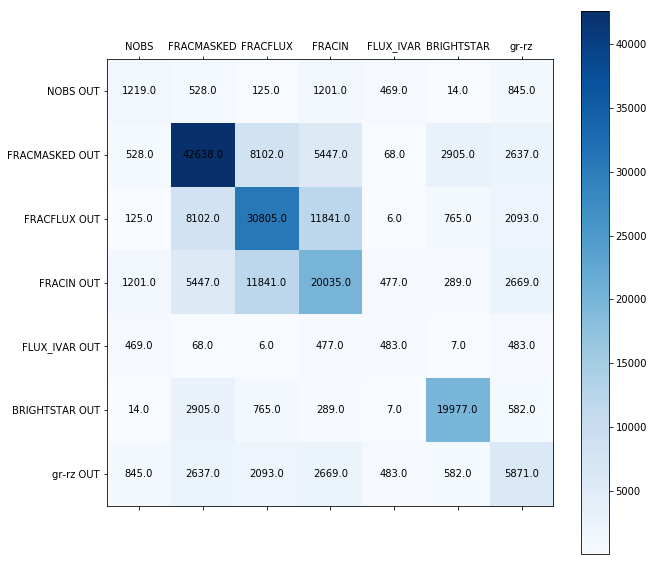

In [180]:
Mu = [[0 for x in range(len(matrix_out))] for y in range(len(matrix_out))] 
    
from itertools import product
for i,j in product(range(len(matrix_out)), range(len(matrix_out))):
    Mu[i][j] = np.array(matrix_out)[i][i] - np.array(matrix_out)[i][j]
    if i == j:
        Mu[i][j] = np.array(matrix_out)[i][j]

    #Mu[i][j] = 100 - 100*np.array(matrix_out)[i][j]/np.array(matrix_out)[i][i]
    #if i == j:
        #Mu[i][j] = 100*np.array(matrix_out)[i][j]/np.array(matrix_out)[i][i]
            
            
#matrix_plot(np.array(matrix_out), np.array(matrix_out.index), np.array(matrix_out.columns))
matrix_plot(Mu, np.array(matrix_out.index), np.array(matrix_out.columns))

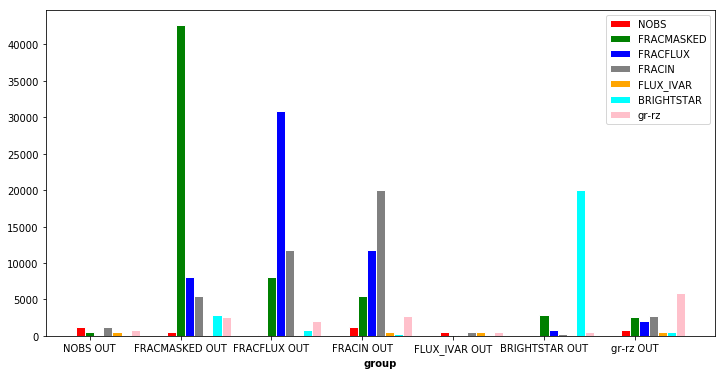

In [115]:
df_Mu = pd.DataFrame(Mu, index=matrix_out.index, columns=matrix_out.columns)
bar_plot(df_Mu)

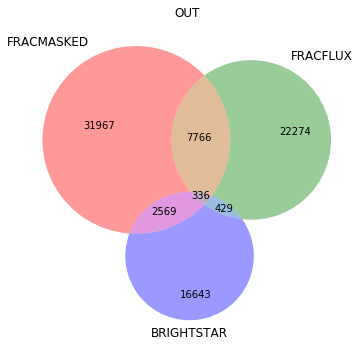

In [116]:
venn_plot(1, 2, 5, ('FRACMASKED', 'FRACFLUX', 'BRIGHTSTAR'), pos='out', title='OUT')

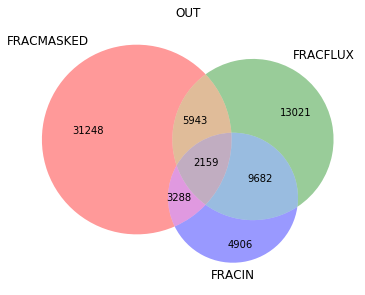

In [117]:
venn_plot(1, 2, 3, ('FRACMASKED', 'FRACFLUX', 'FRACIN'), pos='out', title='OUT')

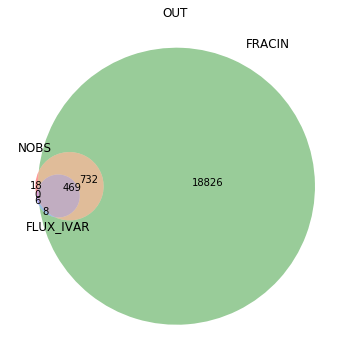

In [118]:
venn_plot(0, 3, 4, ('NOBS', 'FRACIN', 'FLUX_IVAR'), pos='out', title='OUT')

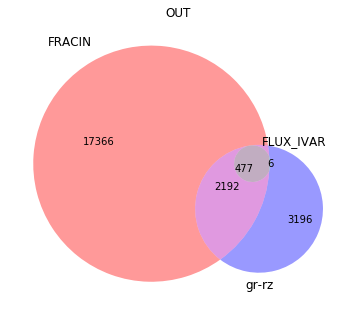

In [52]:
venn_plot( 3, 4, 6, ( 'FRACIN', 'FLUX_IVAR', 'gr-rz'), pos='out', title='OUT')

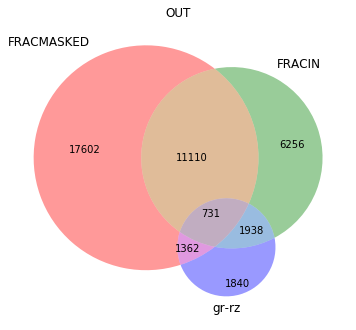

In [53]:
venn_plot( 2,3, 6, ( 'FRACMASKED', 'FRACIN', 'gr-rz'), pos='out', title='OUT')

### G-r Vs g-z

All matchs with GAIA in the sample: 600372


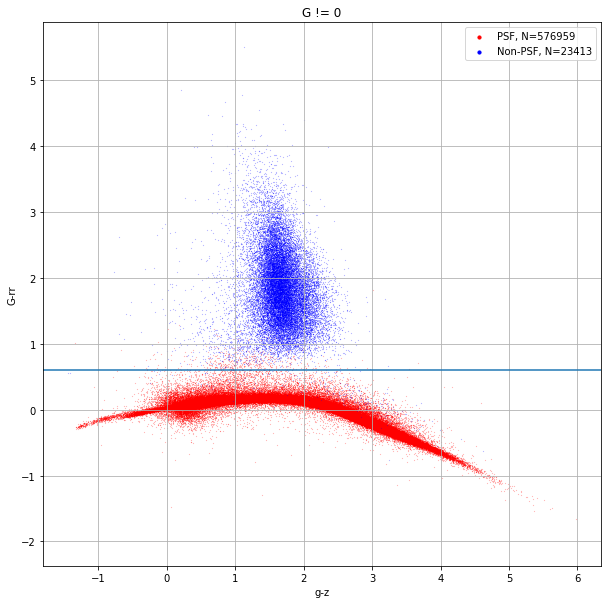

In [33]:
#G-r vs g-z
#del gmag, rmag, zmag, w1mag, Gmag
gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat)

Grr = Gmag - rr  #rr is without extinction correction
Gr = Gmag - rmag

star = cat['TYPE'] == b'PSF ' 
galaxy = cat['TYPE'] != b'PSF '
maskt = Gmag != 0
print('All matchs with GAIA in the sample:',len(cat[maskt]))

plt.figure(figsize=(10, 10))

#plt.scatter(gmag[(star) & (maskt)] - zmag[(star) & (maskt)], Gmag[(star) & (maskt)] - rmag[(star) & (maskt)], s=0.01, color='red', label = r'PSF, N=%g' %(len(gmag[(star) & (maskt)])))

plt.scatter(gmag[(star) & (maskt)] - zmag[(star) & (maskt)], Gmag[(star) & (maskt)] - rr[(star) & (maskt)], s=0.01, color='red', label = r'PSF, N=%g' %(len(gmag[(star) & (maskt)])))

#plt.scatter(gmag[(galaxy) & (maskt)] - zmag[(galaxy) & (maskt)], Gmag[(galaxy) & (maskt)] - rmag[(galaxy) & (maskt)], s=0.01, color='blue', label = r'Non-PSF, N=%g' %(len(gmag[(galaxy) & (maskt)])))

plt.scatter(gmag[(galaxy) & (maskt)] - zmag[(galaxy) & (maskt)], Gmag[(galaxy) & (maskt)] - rr[(galaxy) & (maskt)], s=0.01, color='blue', label = r'Non-PSF, N=%g' %(len(gmag[(galaxy) & (maskt)])))
plt.axhline(0.6)

plt.xlabel(r'g-z')
plt.ylabel(r'G-rr')
plt.title(r'G != 0')
plt.grid()
lgnd = plt.legend(fontsize=10)
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

#### STAR-GALAXY with GAIA:

* GAIA\_GAL = np.concatenate((cat[Grr $>$ 0.6], cat[Gmag == 0])) 

* GAIA\_STAR = cat[(Grr $<$ 0.6) & (Gmag != 0)]

#### STAR-GALAXY with DECaLS DR7:

* DECALS\_GAL = cat[cat['TYPE'] != b'PSF ']

* DECALS\_STAR = cat[cat['TYPE'] == b'PSF '] 

In [90]:
target_con(cat[Grr > 0.6], 'G-r > 0.6')

Total #G-r > 0.6:  23648
Of which...
BGS_ANY: 98 %
QSO: 0.9176 %
LRG: 0.01269 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 0.6174 %
STD: 0.004229 %
STD_BRIGHT: 0.004229 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


In [91]:
target_con(cat[Gmag == 0], 'G == 0')

Total #G == 0:  284062
Of which...
BGS_ANY: 99.89 %
QSO: 0.003168 %
LRG:  0 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 0.04929 %
STD:  0 %
STD_BRIGHT:  0 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


In [92]:
target_con(cat[(Grr < 0.6) & (Gmag != 0)], 'G-r < 0.6 & G != 0')

Total #G-r < 0.6 & G != 0:  573852
Of which...
BGS_ANY: 0.03799 %
QSO: 1.054 %
LRG: 0.0115 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 56.3 %
STD: 6.458 %
STD_BRIGHT: 3.447 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


### r-z Vs g-r 

cat with Grr > 0.6: 23673
cat with Gmag = 0: 285533
concatenate cat: 309206


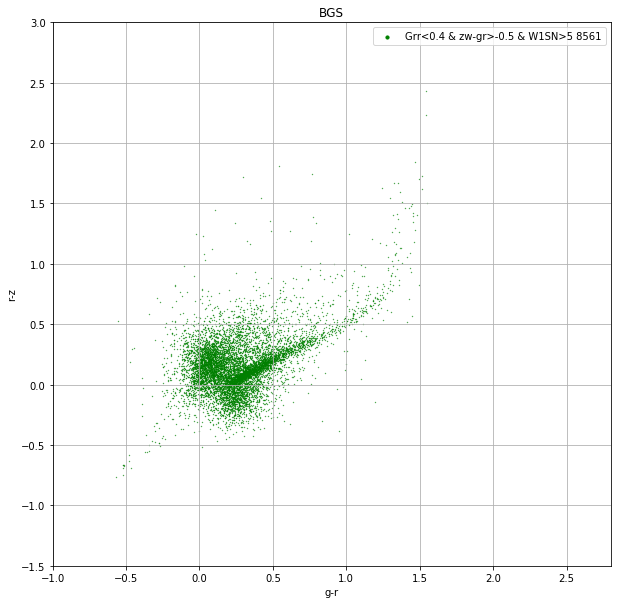

In [58]:
#r-z vs g-r

cat_bgs = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0]))
print('cat with Grr > 0.6:',len(cat[Grr > 0.6]))
print('cat with Gmag = 0:',len(cat[Gmag == 0]))
print('concatenate cat:', len(cat_bgs))

g, r, z, w1, G, rr = get_mag_decals(cat_bgs)

Gstar = G[cat_bgs['TYPE'] == b'PSF ']
Ggalaxy = G[cat_bgs['TYPE'] != b'PSF ']

gr_star = g[cat_bgs['TYPE'] == b'PSF '] - r[cat_bgs['TYPE'] == b'PSF ']
rz_star = r[cat_bgs['TYPE'] == b'PSF '] - z[cat_bgs['TYPE'] == b'PSF ']
gr_galaxy = g[cat_bgs['TYPE'] != b'PSF '] - r[cat_bgs['TYPE'] != b'PSF ']
rz_galaxy = r[cat_bgs['TYPE'] != b'PSF '] - z[cat_bgs['TYPE'] != b'PSF ']

#del g1, r1, z1, w11, G1, g, r, z, w1, G, GAIA_STAR
mask_star = np.logical_and(Grr < 0.4, Grr > -1)
GAIA_STAR = cat[mask_star]
g, r, z, w1, G, rr = get_mag_decals(GAIA_STAR)
GAIA_STARup =GAIA_STAR[(z - w1 - (g - r) > -0.5) & (GAIA_STAR['FLUX_W1']*np.sqrt(GAIA_STAR['FLUX_IVAR_W1']) > 5)]
g1, r1, z1, w11, G1, rr1 = get_mag_decals(GAIA_STARup)

plt.figure(figsize=(10, 10))

#plt.scatter(gr_galaxy, rz_galaxy, s=0.01, color='green', label = r'Grr>0.6 & non-PSF, N=%g' %(len(gr_galaxy)))
plt.scatter(g1 - r1, r1 - z1, s=0.1, color='green', label = r'Grr<0.4 & zw-gr>-0.5 & W1SN>5 %#i' %(len(g1)))
#plt.scatter(gr_star[Gstar != 0], rz_star[Gstar != 0], s=0.8, color='red', label = r'Grr>0.6 & PSF & G != 0, N=%g' %(len(gr_star[Gstar != 0])))
#plt.scatter(gr_star[Gstar == 0], rz_star[Gstar == 0], s=0.8, color='blue', label = r'Grr>0.6 & PSF & G==0, N=%g' %(len(gr_star[Gstar == 0])))

#plt.scatter(gmag[Gmag == 0] - rmag[Gmag == 0], rmag[Gmag == 0] - zmag[Gmag == 0], s=0.1, color='red')
#plt.scatter(gmag[Grr > 0.9] - rmag[Grr > 0.9], rmag[Grr > 0.9] - zmag[Grr > 0.9], s=0.1, color='black')
plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
#plt.title(r'Grr > 0.6 & !GAIA')
plt.title(r'BGS')
plt.xlim(-1, 2.8)
plt.ylim(-1.5, 3)
plt.grid()
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [62]:
rflux = GAIA_STAR['FLUX_R'] / GAIA_STAR['MW_TRANSMISSION_R']
gflux = GAIA_STAR['FLUX_G'] / GAIA_STAR['MW_TRANSMISSION_G']
zflux = GAIA_STAR['FLUX_Z'] / GAIA_STAR['MW_TRANSMISSION_Z']
w1flux = GAIA_STAR['FLUX_W1'] / GAIA_STAR['MW_TRANSMISSION_W1']

print('mag',len(GAIA_STAR[z - w1 - (g - r) > -0.5]))
print('flux',len(GAIA_STAR[w1flux*gflux > (zflux*rflux)*10**(-0.2)]))

mag 8562
flux 8562


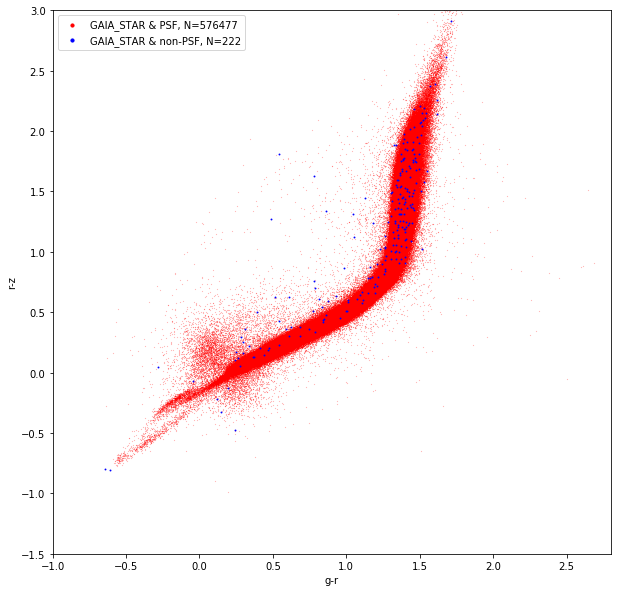

In [35]:
# r-z vs g-r
#Grr = Gmag - rmag
GAIA_GAL = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0]))
GAIA_STAR = cat[(Grr  <  0.6) & (Gmag != 0)]

g1, r1, z1, w11, G1, rr1 = get_mag_decals(GAIA_GAL)
g2, r2, z2, w12, G2, rr2 = get_mag_decals(GAIA_STAR)

#GAIA GALAXIES
gr_GAL_psf = g1[GAIA_GAL['TYPE'] == b'PSF '] - r1[GAIA_GAL['TYPE'] == b'PSF ']
rz_GAL_psf = r1[GAIA_GAL['TYPE'] == b'PSF '] - z1[GAIA_GAL['TYPE'] == b'PSF ']
gr_GAL_nopsf = g1[GAIA_GAL['TYPE'] != b'PSF '] - r1[GAIA_GAL['TYPE'] != b'PSF ']
rz_GAL_nopsf = r1[GAIA_GAL['TYPE'] != b'PSF '] - z1[GAIA_GAL['TYPE'] != b'PSF ']

#GAIA STARS
gr_STAR_psf = g2[GAIA_STAR['TYPE'] == b'PSF '] - r2[GAIA_STAR['TYPE'] == b'PSF ']
rz_STAR_psf = r2[GAIA_STAR['TYPE'] == b'PSF '] - z2[GAIA_STAR['TYPE'] == b'PSF ']
gr_STAR_nopsf = g2[GAIA_STAR['TYPE'] != b'PSF '] - r2[GAIA_STAR['TYPE'] != b'PSF ']
rz_STAR_nopsf = r2[GAIA_STAR['TYPE'] != b'PSF '] - z2[GAIA_STAR['TYPE'] != b'PSF ']

plt.figure(figsize=(10, 10))

#plt.scatter(gr_GAL_nopsf, rz_GAL_nopsf, s=0.01, color='blue', label = r'GAIA_GAL & non-PSF, N=%g' %(len(gr_GAL_nopsf)))
#plt.scatter(gr_GAL_psf, rz_GAL_psf, s=0.08, color='red', label = r'GAIA_GAL & PSF, N=%g' %(len(gr_GAL_psf)))

plt.scatter(gr_STAR_psf, rz_STAR_psf, s=0.01, color='red', label = r'GAIA_STAR & PSF, N=%g' %(len(gr_STAR_psf)))
plt.scatter(gr_STAR_nopsf, rz_STAR_nopsf, s=0.8, color='blue', label = r'GAIA_STAR & non-PSF, N=%g' %(len(gr_STAR_nopsf)))

plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
#plt.title(r'')
#plt.grid()
plt.xlim(-1, 2.8)
plt.ylim(-1.5, 3)
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [36]:
target_Ggal = target_con(cat_bgs, 'Grr > 0.6 Or G==0')

Total #Grr > 0.6 Or G==0:  309206
Of which...
BGS_ANY: 99.73 %
QSO: 0.07309 %
LRG: 0.0009702 %
MWS_ANY: 0.09605 %
STD: 0.0003234 %
STD_BRIGHT: 0.0003234 %
G==0: 92.34 %
PSF: 0.2668 %
no-PSF: 99.73 %


In [166]:
target_con(GAIA_STAR, 'Grr < 0.6 + G!=0')

Total #Grr < 0.6 + G!=0:  576699
Of which...
BGS_ANY: 0.03849 %
QSO: 1.049 %
LRG: 0.01144 %
MWS_ANY: 56.13 %
STD: 6.432 %
STD_BRIGHT: 3.431 %
G==0:  0 %
PSF: 99.96 %
no-PSF: 0.03849 %


[['BGS_ANY', 0.03849495143913896],
 ['QSO', 1.0489007263754575],
 ['LRG', 0.011444445022446719],
 ['MWS_ANY', 56.13448263305468],
 ['STD', 6.432124903979372],
 ['STD_BRIGHT', 3.430732496501641],
 ['G==0', 0.0],
 ['PSF', 99.96150504856087],
 ['no-PSF', 0.03849495143913896]]

In [167]:
target_con(GAIA_STARup, 'Grr<0.4 & zw-gr>-0.5 & W1SN>5')

Total #Grr<0.4 & zw-gr>-0.5 & W1SN>5:  7641
Of which...
BGS_ANY: 0.05235 %
QSO: 60.95 %
LRG: 0.2094 %
MWS_ANY: 27.82 %
STD: 1.034 %
STD_BRIGHT: 0.1178 %
G==0:  0 %
PSF: 99.95 %
no-PSF: 0.05235 %


[['BGS_ANY', 0.05234916895694281],
 ['QSO', 60.947519958120665],
 ['LRG', 0.20939667582777124],
 ['MWS_ANY', 27.823583300615102],
 ['STD', 1.0338960868996205],
 ['STD_BRIGHT', 0.11778563015312132],
 ['G==0', 0.0],
 ['PSF', 99.94765083104306],
 ['no-PSF', 0.05234916895694281]]

In [95]:
#Save catalogue for visualization in yymao:https://yymao.github.io/decals-image-list-tool/
t_psf= Table()
t_nopsf= Table()
CAT_PSF = cat_bgs[cat_bgs['TYPE'] == b'PSF ']
CAT_NOPSF = GAIA_STAR[GAIA_STAR['TYPE'] != b'PSF ']
t_psf['ra'] = CAT_PSF['RA']
t_psf['dec'] = CAT_PSF['DEC']
t_nopsf['ra'] = CAT_NOPSF['RA']
t_nopsf['dec'] = CAT_NOPSF['DEC']
#ascii.write(t_nopsf[:150], 'separation_NOPSF.dat', overwrite=True)

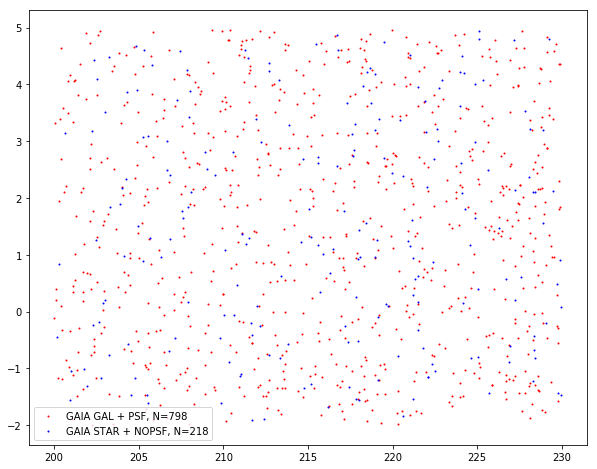

In [96]:
plt.figure(figsize=(10,8))
plt.scatter(t_psf['ra'], t_psf['dec'], s=1, color='red', label = r'GAIA GAL + PSF, N=%g' %(len(t_psf)))
plt.scatter(t_nopsf['ra'], t_nopsf['dec'], s=1, color='blue', label = r'GAIA STAR + NOPSF, N=%g' %(len(t_nopsf)))
plt.legend()

In [97]:
target_con(CAT_NOPSF, 'GAIA STAR + NOPSF')

Total #GAIA STAR + NOPSF:  218
Of which...
BGS_ANY: 100 %
QSO:  0 %
LRG:  0 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 0.9174 %
STD:  0 %
STD_BRIGHT:  0 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


In [98]:
target_con(CAT_PSF, 'GAIA GAL + PSF')

Total #GAIA GAL + PSF:  798
Of which...
BGS_ANY:  0 %
QSO: 28.32 %
LRG: 0.3759 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 35.34 %
STD: 0.1253 %
STD_BRIGHT: 0.1253 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


### Ratio of galaxies and Stars defined by GAIA and DECaLS

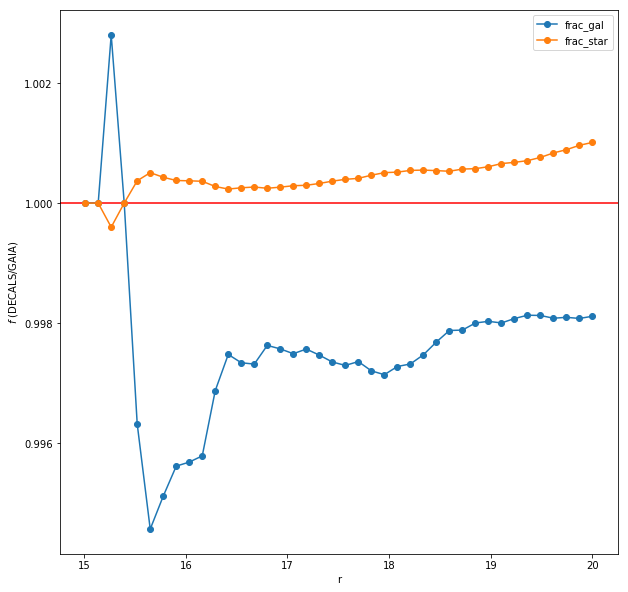

In [99]:
r_tmp = np.linspace(15.01,20,40)
frac_gal = np.zeros(len(r_tmp), dtype='f8')
frac_star = np.zeros(len(r_tmp), dtype='f8')
del g,r,z, w1, G, rr
g, r, z, w1, G, rr = get_mag_decals(cat)
j = 0
for i in r_tmp:
    DECALS_GAL = cat[r <= i]
    DECALS_STAR = cat[r <= i]
    frac_gal[j] = len(DECALS_GAL[DECALS_GAL['TYPE'] != b'PSF '])/len(GAIA_GAL[r1 <= i])
    frac_star[j] = len(DECALS_STAR[DECALS_STAR['TYPE'] == b'PSF '])/len(GAIA_STAR[r2 <= i])
    j = j + 1

plt.figure(figsize=(10, 10))

plt.axhline(1, color='red')
plt.plot(r_tmp, frac_gal, marker='o', label=r'frac_gal')
plt.plot(r_tmp, frac_star, marker='o', label=r'frac_star')

plt.xlabel(r'r')
plt.ylabel(r'$f$ (DECALS/GAIA)')
lgnd = plt.legend()
plt.show()

### z-w1-(g-r) Vs g-r for 0.4 > G-r > -1

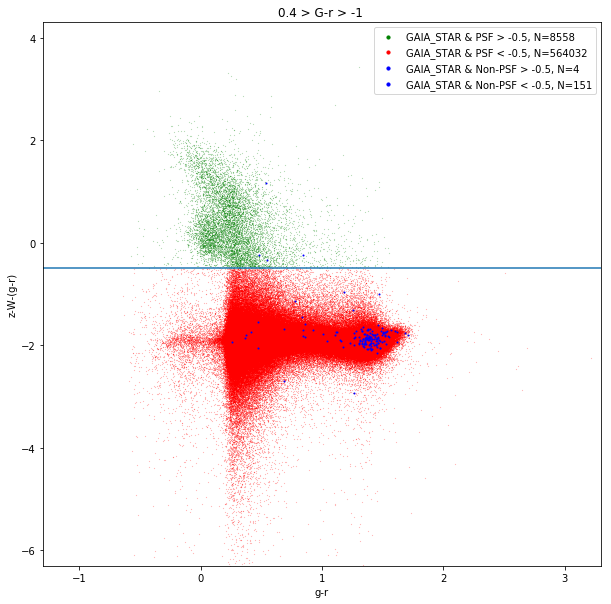

In [100]:
#del GAIA_STAR
#del g,r,z,w1,G,rr

mask_star = np.logical_and(Grr < 0.4, Grr > -1)
GAIA_STAR = cat[mask_star]
g, r, z, w1, G, rr = get_mag_decals(GAIA_STAR)
GAIA_STARup =GAIA_STAR[z - w1 - (g - r) > -0.5]
GAIA_STARdown =GAIA_STAR[z - w1 - (g - r) < -0.5]

g1, r1, z1, w11, G1, rr1 = get_mag_decals(GAIA_STARup)
g2, r2, z2, w12, G2, rr2 = get_mag_decals(GAIA_STARdown)

#GAIA ULTIMATE STARS UP
gr_psf_up = g1[GAIA_STARup['TYPE'] == b'PSF '] - r1[GAIA_STARup['TYPE'] == b'PSF ']
zw_psf_up = z1[GAIA_STARup['TYPE'] == b'PSF '] - w11[GAIA_STARup['TYPE'] == b'PSF '] - (gr_psf_up)
gr_nopsf_up = g1[GAIA_STARup['TYPE'] != b'PSF '] - r1[GAIA_STARup['TYPE'] != b'PSF ']
zw_nopsf_up = z1[GAIA_STARup['TYPE'] != b'PSF '] - w11[GAIA_STARup['TYPE'] != b'PSF '] - (gr_nopsf_up)
#GAIA ULTIMATE STARS DOWN
gr_psf_down = g2[GAIA_STARdown['TYPE'] == b'PSF '] - r2[GAIA_STARdown['TYPE'] == b'PSF ']
zw_psf_down = z2[GAIA_STARdown['TYPE'] == b'PSF '] - w12[GAIA_STARdown['TYPE'] == b'PSF '] - (gr_psf_down)
gr_nopsf_down = g2[GAIA_STARdown['TYPE'] != b'PSF '] - r2[GAIA_STARdown['TYPE'] != b'PSF ']
zw_nopsf_down = z2[GAIA_STARdown['TYPE'] != b'PSF '] - w12[GAIA_STARdown['TYPE'] != b'PSF '] - (gr_nopsf_down)

plt.figure(figsize=(10, 10))

plt.scatter(gr_psf_up, zw_psf_up, s=0.01, color='green', label = r'GAIA_STAR & PSF > -0.5, N=%g' %(len(zw_psf_up)))
plt.scatter(gr_psf_down, zw_psf_down, s=0.01, color='red', label = r'GAIA_STAR & PSF < -0.5, N=%g' %(len(zw_psf_down)))

plt.scatter(gr_nopsf_up, zw_nopsf_up, s=1, color='blue', label = r'GAIA_STAR & Non-PSF > -0.5, N=%g' %(len(zw_nopsf_up)))
plt.scatter(gr_nopsf_down, zw_nopsf_down, s=1, color='blue', label = r'GAIA_STAR & Non-PSF < -0.5, N=%g' %(len(zw_nopsf_down)))
plt.axhline(-0.5)

plt.xlabel(r'g-r')
plt.ylabel(r'z-W-(g-r)')
plt.title(r'0.4 > G-r > -1 ')
#plt.grid()
plt.xlim(-1.3, 3.3)
plt.ylim(-6.3, 4.3)
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [101]:
target_con(GAIA_STARup, 'GAIA STAR with z-w1-(g-r) > -0.5')

Total #GAIA STAR with z-w1-(g-r) > -0.5:  8562
Of which...
BGS_ANY: 0.04672 %
QSO: 62.05 %
LRG: 0.1869 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 25.29 %
STD: 0.9227 %
STD_BRIGHT: 0.1051 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


In [102]:
target_con(GAIA_STARdown, 'GAIA STAR with z-w1-(g-r) < -0.5')

Total #GAIA STAR with z-w1-(g-r) < -0.5:  564183
Of which...
BGS_ANY: 0.02676 %
QSO: 0.07125 %
LRG: 0.008862 %
ELG:  0 %
BAD_SKY:  0 %
NO_TARGET:  0 %
BRIGHT_OBJECT:  0 %
MWS_ANY: 56.82 %
STD: 6.555 %
STD_BRIGHT: 3.504 %
STD_WD:  0 %
IN_BRIGHT_OBJECT:  0 %
NEAR_BRIGHT_OBJECT:  0 %


BGS ultimate

* Not GAIA
* G-r > 0.9
* 0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4
* -1 < G-rr < 0.4 and z-W1-(g-r)>-0.5

and then we concatenate everything.

G-r > 0.9= 22800
Not GAIA= 284062
0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4= 376
-1 < G-rr < 0.4 and z-W1-(g-r)>-0.5= 8562
TOTAL=315800
CONCATENATE CAT= 316648


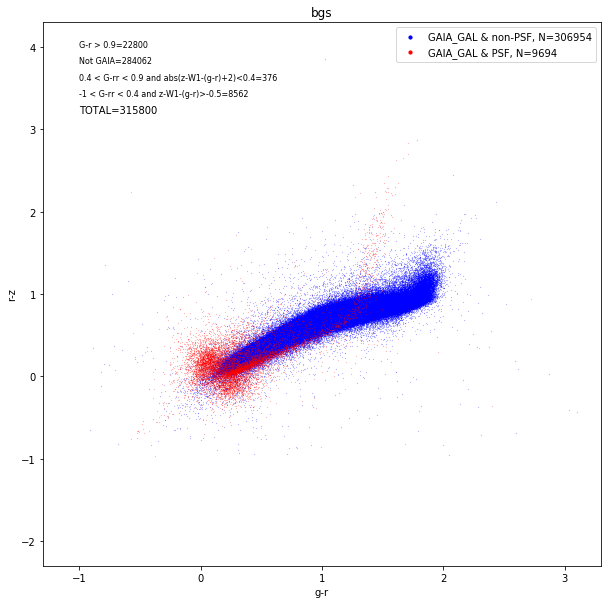

In [46]:
#del GAIA_GAL
#del g,r,z,w1,G, rr
mask_bgs1 = np.logical_and(Grr < 0.6, Grr > 0.4)
mask_bgs1 &= abs(zmag - w1mag - (gmag - rmag) + 2) < 0.4

mask_bgs2 = np.logical_and(Grr < 0.4, Grr > -1)
mask_bgs2 &= zmag - w1mag - (gmag - rmag) > -0.5

GAIA_GAL = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0], cat[mask_bgs1], cat[mask_bgs2]))
print('G-r > 0.9=',len(cat[Grr > 0.9]))
print('Not GAIA=',len(cat[Gmag == 0]))
print('0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4=',len(cat[mask_bgs1]))
print('-1 < G-rr < 0.4 and z-W1-(g-r)>-0.5=',len(cat[mask_bgs2]))
print('TOTAL=%g' %(len(cat[Grr > 0.9])+len(cat[Gmag == 0])+len(cat[mask_bgs1])+len(cat[mask_bgs2])))

print('CONCATENATE CAT=',len(GAIA_GAL))

g, r, z, w1, G, rr = get_mag_decals(GAIA_GAL)

#GAIA ULTIMATE GALAXIES
gr_GAL_psf = g[GAIA_GAL['TYPE'] == b'PSF '] - r[GAIA_GAL['TYPE'] == b'PSF ']
rz_GAL_psf = r[GAIA_GAL['TYPE'] == b'PSF '] - z[GAIA_GAL['TYPE'] == b'PSF ']
gr_GAL_nopsf = g[GAIA_GAL['TYPE'] != b'PSF '] - r[GAIA_GAL['TYPE'] != b'PSF ']
rz_GAL_nopsf = r[GAIA_GAL['TYPE'] != b'PSF '] - z[GAIA_GAL['TYPE'] != b'PSF ']

plt.figure(figsize=(10, 10))

plt.scatter(gr_GAL_nopsf, rz_GAL_nopsf, s=0.01, color='blue', label = r'GAIA_GAL & non-PSF, N=%g' %(len(gr_GAL_nopsf)))
plt.scatter(gr_GAL_psf, rz_GAL_psf, s=0.01, color='red', label = r'GAIA_GAL & PSF, N=%g' %(len(gr_GAL_psf)))
plt.text(-1, 4, r'G-r > 0.9=%g'%(len(cat[Grr > 0.9])), fontsize=8)
plt.text(-1, 3.8, r'Not GAIA=%g'%(len(cat[Gmag == 0])), fontsize=8)
plt.text(-1, 3.6, r'0.4 < G-rr < 0.9 and abs(z-W1-(g-r)+2)<0.4=%g' %(len(cat[mask_bgs1])), fontsize=8)
plt.text(-1, 3.4, r'-1 < G-rr < 0.4 and z-W1-(g-r)>-0.5=%g' %(len(cat[mask_bgs2])), fontsize=8)
plt.text(-1,3.2, r'TOTAL=%g' %(len(cat[Grr > 0.9])+len(cat[Gmag == 0])+len(cat[mask_bgs1])+len(cat[mask_bgs2])), fontsize=10)

plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
plt.title(r'bgs')
#plt.grid()
plt.xlim(-1.3, 3.3)
plt.ylim(-2.3, 4.3)
lgnd = plt.legend(loc='upper right')
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

## DEV ZONE 

#### Distributions...

In [165]:
def hist_decals(df, name, tuningL, tuningR, limit, LOG):
    
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    
    print('Z MAX-MIN=',df[name+'_Z'].max(), df[name+'_Z'].min())
    print('G MAX-MIN=',df[name+'_G'].max(), df[name+'_G'].min())
    print('R MAX-MIN=',df[name+'_R'].max(), df[name+'_R'].min())
    
    plt.figure(figsize=(12, 7))
    plt.hist(df[name+'_Z'][(df[name+'_Z'] < tuningR) & (df[name+'_Z'] > tuningL)], 500, histtype='step', cumulative=True, stacked=True, fill=False, label=r'z', linewidth=3.0)
    plt.hist(df[name+'_G'][(df[name+'_G'] < tuningR) & (df[name+'_G'] > tuningL)], 500, histtype='step', cumulative=True, stacked=True, fill=False, label=r'g', alpha=0.6, linewidth=3.0)
    plt.hist(df[name+'_R'][(df[name+'_R'] < tuningR) & (df[name+'_R'] > tuningL)], 500, histtype='step', cumulative=True, stacked=True, fill=False, label=r'r', alpha=0.5, linewidth=3.0)
    plt.axvline(x=limit, color=r'black')
    #plt.xlim(0, 30)
    plt.title(name)
    if LOG == 'loglog':
        plt.yscale('log')
        plt.xscale('log')
    if LOG == 'logx':
        plt.xscale('log')
    if LOG == 'logy':
        plt.yscale('log')
    plt.legend()
    plt.grid()

In [166]:
N1 = len(cat0[(cat0['NOBS_R'] >= 3) & (cat0['NOBS_Z'] >= 3) & (cat0['NOBS_G'] >= 3)])
N2 = len(cat0)
print(N1/N2)

0.7488577878570535


In [ ]:
del r
g, r, z, w1, G, rr = get_mag_decals(cat0)
mask3 =  np.logical_and(r > 15, r < 20)
cat0 = cat0[mask3]

Z MAX-MIN= 1.03737 7.03033e-07
G MAX-MIN= 1.02496 3.08656e-06
R MAX-MIN= 1.07858 1.70083e-05


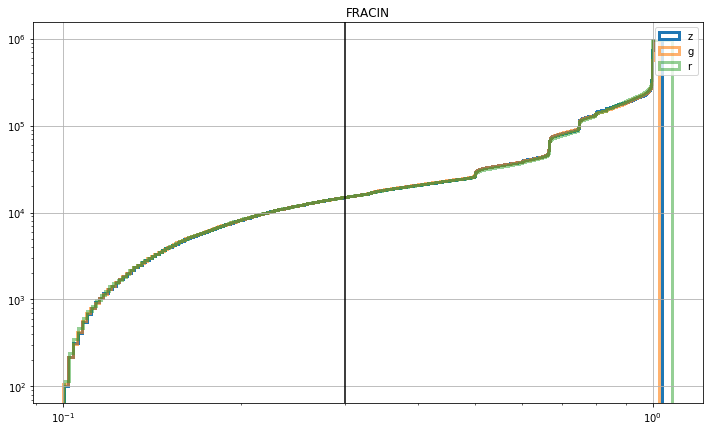

In [167]:
hist_decals(catr, 'FRACIN', 0.1, 60, 0.3, 'loglog')

Z MAX-MIN= 41.2368 0.0
G MAX-MIN= 60.8369 0.0
R MAX-MIN= 45.0958 0.0


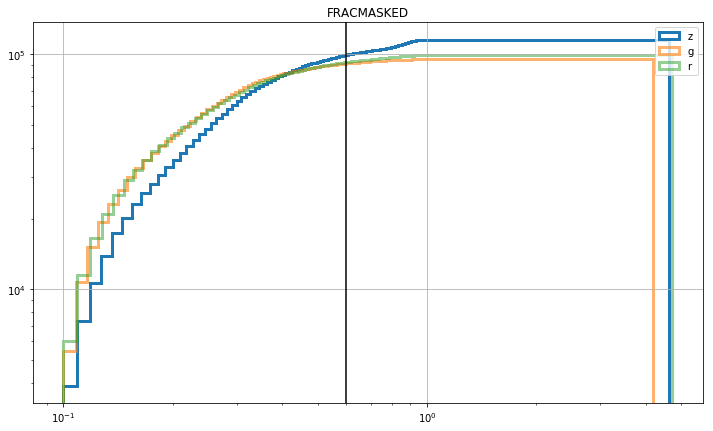

In [168]:
hist_decals(catr, 'FRACMASKED', 0.1,5, 0.6, 'loglog')

Z MAX-MIN= 494118.0 -196.057
G MAX-MIN= 112529.0 -2175.9
R MAX-MIN= 6734.15 -1594.58


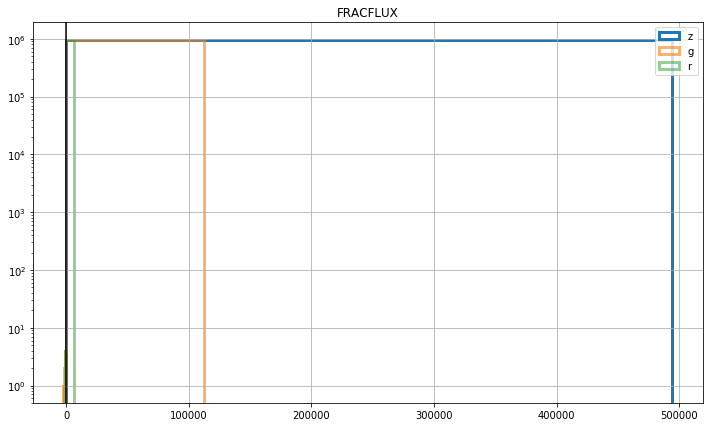

In [169]:
hist_decals(catr, 'FRACFLUX', -2798.65, 494118.0, -0, 'logy')

Z MAX-MIN= 494118.0 -196.057
G MAX-MIN= 112529.0 -2175.9
R MAX-MIN= 6734.15 -1594.58


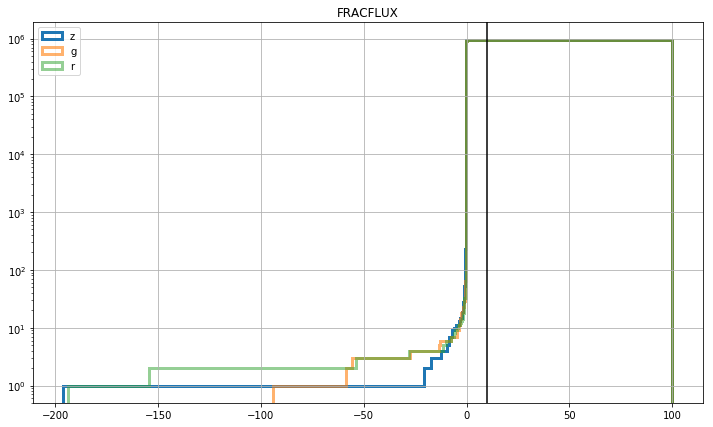

In [170]:
hist_decals(catr, 'FRACFLUX', -200, 100, 10, 'logy')

Z MAX-MIN= 24 0
G MAX-MIN= 48 0
R MAX-MIN= 77 0


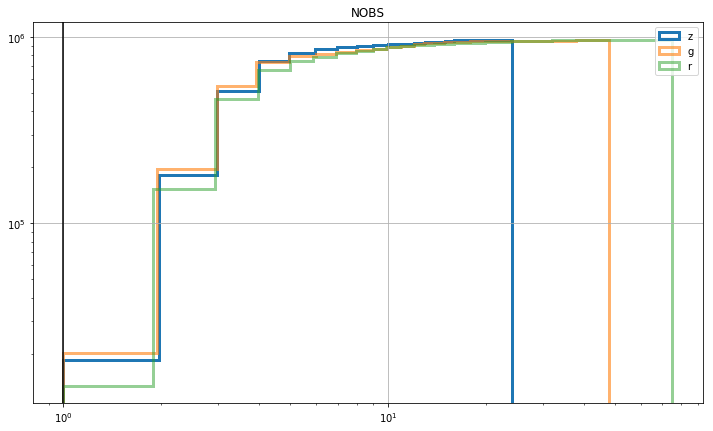

In [171]:
hist_decals(catr, 'NOBS', 0.001, 77, 1, 'loglog')

Z MAX-MIN= 24 0
G MAX-MIN= 48 0
R MAX-MIN= 77 0


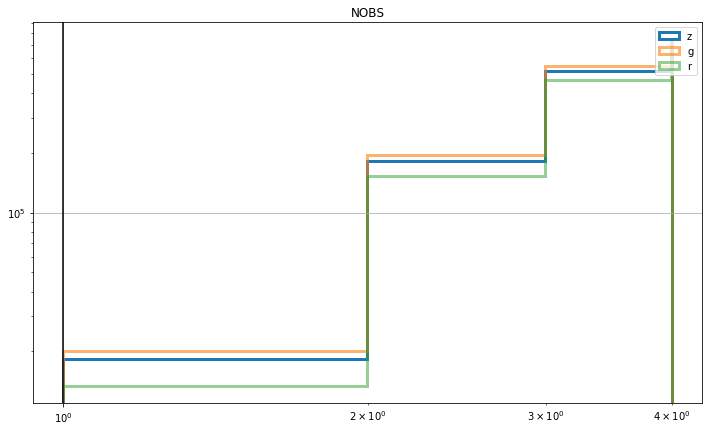

In [172]:
hist_decals(catr, 'NOBS', 0.001, 5, 1, 'loglog')

Z MAX-MIN= 1358.81 2.32142e-11
G MAX-MIN= 12510.2 6.82927e-12
R MAX-MIN= 6974.0 8.96007e-08


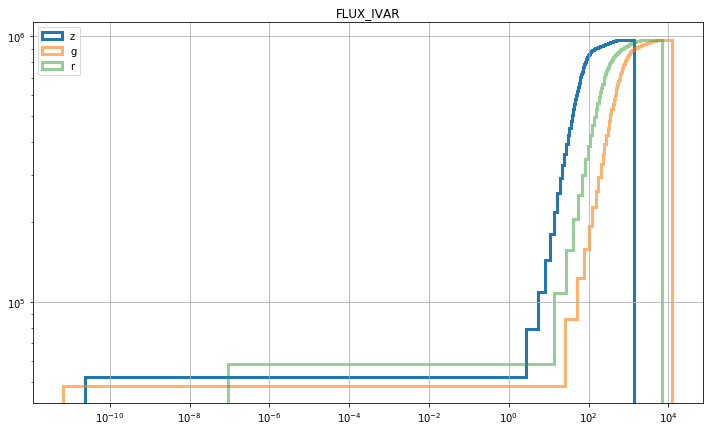

In [173]:
#* g+z-2*r<1.5 and g-r>-1. --This cuts junk where the r band or g band are anomalously bright
hist_decals(catr, 'FLUX_IVAR', 0, 16863.6, 0, 'loglog')

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


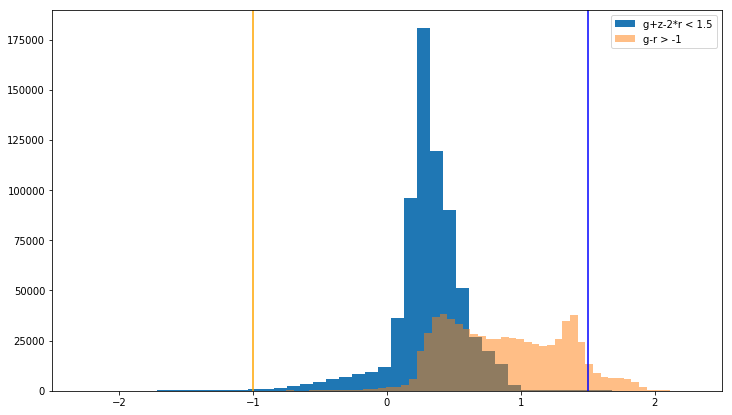

In [185]:
#del g, r, z, w1, G
g, r, z, w, G = get_mag_decals(cat0)
g = g[np.logical_and(r>=15, r<=20)]
z = z[np.logical_and(r>=15, r<=20)]
r = r[np.logical_and(r>=15, r<=20)]

plt.figure(figsize=(12, 7))
plt.hist(g+z-2*r, 300, label=r'g+z-2*r < 1.5')
plt.hist(g-r, 300, alpha=0.5, label=r'g-r > -1')
plt.axvline(x=1.5, color=r'blue')
plt.axvline(x=-1, color=r'orange')
plt.xlim(-2.5, 2.5)
plt.legend()

In [109]:
tG_psf= Table()

tG_psf['ra'] = GAIA_STARup['RA']
tG_psf['dec'] = GAIA_STARup['DEC']

ascii.write(tG_psf[::50], 'GAIA_STARup.dat', overwrite=True)

### TESTS...

In [60]:
print('loading desitarget NEW')
columns0 = ['RA', 'DEC', 'DESI_TARGET', 'BGS_TARGET']
catT2 = fitsio.read('/global/homes/q/qmxp55/DESI/desitarget_data/targetdir/targets-dr7.1-0.26.0.fits', columns=columns0, ext=1)
catT2 = cut(200, 230, -2,5, catT2)
print('# DESITARGET NEW', len(catT2))

loading desitarget NEW
# DESITARGET NEW 1517291


In [61]:
from desitarget.targetmask import desi_mask, bgs_mask

In [63]:
#load desitarget with new BGS target selection
def testx():

    Nbgs_target_old_faint = len(catT[((np.uint64(catT['BGS_TARGET']) & np.uint64(bgs_mask['BGS_FAINT']))!=0)])
    Nbgs_target_old_bright = len(catT[((np.uint64(catT['BGS_TARGET']) & np.uint64(bgs_mask['BGS_BRIGHT']))!=0)])
    Nbgs_target_old = len(catT[((np.uint64(catT['DESI_TARGET']) & np.uint64(desi_mask['BGS_ANY']))!=0)])
    Nbgs_target_new_faint = len(catT2[((np.uint64(catT2['BGS_TARGET']) & np.uint64(bgs_mask['BGS_FAINT']))!=0)])
    Nbgs_target_new_bright = len(catT2[((np.uint64(catT2['BGS_TARGET']) & np.uint64(bgs_mask['BGS_BRIGHT']))!=0)])
    Nbgs_target_new_wise = len(catT2[((np.uint64(catT2['BGS_TARGET']) & np.uint64(bgs_mask['BGS_KNOWN_ANY']))!=0)])
    Nbgs_target_new = len(catT2[((np.uint64(catT2['DESI_TARGET']) & np.uint64(desi_mask['BGS_ANY']))!=0)])


    rflux = catS['FLUX_R'] / catS['MW_TRANSMISSION_R']
    bgs = rflux > 10**((22.5-20.0)/2.5)
    bgs &= catS['TYPE'] != b'PSF '
    bgs_faint = rflux > 10**((22.5-20.0)/2.5)
    bgs_faint &= rflux <= 10**((22.5-19.5)/2.5)
    bgs_faint &= catS['TYPE'] != b'PSF '
    bgs_bright = rflux <= 10**((22.5-19.5)/2.5)
    bgs_bright &= catS['TYPE'] != b'PSF '

    gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat)
    Grr = Gmag - rr  #rr is without extinction correction
    bgs_new = Grr > 0.6
    bgs_new |= Gmag == 0
    cat_new = cat[bgs_new]
    g, r, z, w1, G, rr = get_mag_decals(cat_new)
    bgs_wise = Grr < 0.4
    bgs_wise &= Grr > -1.0
    bgs_wise &= zmag - w1mag - (gmag - rmag) > -0.5
    bgs_wise &= cat['FLUX_W1']*np.sqrt(cat['FLUX_IVAR_W1']) > 5
    
    print(np.sum(catS['BRIGHTSTARINBLOB']))
    print('------------------------')
    
    print('BGS_FAINT (DESITARGET OLD, ME):', Nbgs_target_old_faint, len(catS[bgs_faint]))
    print('BGS_BRIGHT (DESITARGET OLD, ME):', Nbgs_target_old_bright, len(catS[bgs_bright]))
    print('BGS_TOTAL (DESITARGET OLD, ME):', Nbgs_target_old, len(catS[bgs]))
    print('===================================')
    print('BGS_FAINT (DESITARGET NEW, ME):', Nbgs_target_new_faint, len(cat_new[np.logical_and(r < 20, r >= 19.5)]))
    print('BGS_BRIGHT (DESITARGET NEW, ME):', Nbgs_target_new_bright, len(cat_new[r < 19.5]))
    print('BGS_WISE (DESITARGET NEW, ME):', Nbgs_target_new_wise, len(cat[bgs_wise]))
    print('BGS_TOTAL (DESITARGET NEW, ME):', Nbgs_target_new, len(cat[bgs_wise]) + len(cat_new[np.logical_and(r < 20, r >= 19.5)]) + len(cat_new[r < 19.5]))


In [64]:
testx()

306564
------------------------
BGS_FAINT (DESITARGET OLD, ME): 130266 130266
BGS_BRIGHT (DESITARGET OLD, ME): 219711 9642444
BGS_TOTAL (DESITARGET OLD, ME): 349977 349977
BGS_FAINT (DESITARGET NEW, ME): 124012 124009
BGS_BRIGHT (DESITARGET NEW, ME): 186030 186029
BGS_WISE (DESITARGET NEW, ME): 8561 8561
BGS_TOTAL (DESITARGET NEW, ME): 318603 318599
